<a href="https://colab.research.google.com/github/raghunadh-eva/eva6/blob/master/S7_ASSIGNMENT/CODE4_86P_DILATION.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Basic setup block**


*   Load the required utils/libraries
*   Setup the transformations needed to load the data
*   Split the input data into train and test
*   Create the train and test data objects





In [1]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms, utils
%matplotlib inline
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import StepLR
!pip install torchsummary
from torchsummary import summary
import numpy as np

In [2]:
!pip install -U albumentations
import albumentations as A
import cv2


import albumentations as A
from albumentations.pytorch import ToTensorV2

Requirement already up-to-date: albumentations in /usr/local/lib/python3.7/dist-packages (1.0.0)


In [3]:
test_transforms  = transforms.Compose([
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.4914,0.4822,0.4465), (0.247,0.2435,0.2616))
                                      ])

In [4]:
train_transforms_a = A.Compose([
                                       A.Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.247, 0.2435, 0.2616)),
                                       A.HorizontalFlip(p=0.5),
                                       A.ShiftScaleRotate(),
                                       A.CoarseDropout(max_holes=1,max_height=16,max_width=16,min_holes=1,min_height=16,min_width=16,fill_value=(0.4914, 0.4822, 0.4465),mask_fill_value=None),
                                       ToTensorV2()
                                       ])

In [5]:
import cv2
import torchvision

##copied from albumentations.io
cv2.setNumThreads(0)
cv2.ocl.setUseOpenCL(False)

class data_albumentations(datasets.CIFAR10):
    def __init__(self, root="~/data/cifar10", train=True, download=True, transform=None):
        super().__init__(root=root, train=train, download=download, transform=transform)

    def __getitem__(self, index):
        image, label = self.data[index], self.targets[index]

        if self.transform is not None:
            transformed = self.transform(image=image)
            image = transformed["image"]

        return image, label



In [6]:
#train = datasets.CIFAR10('./data', train=True,  download=True, transform=train_transforms)
train = data_albumentations(train=True,  download=True, transform=train_transforms_a)
test =  datasets.CIFAR10('./data', train=False, download=True, transform=test_transforms)


Files already downloaded and verified
Files already downloaded and verified


In [7]:
#Always start with same random set everytime
SEED = 1

#Is GPU ?
cuda = torch.cuda.is_available()

print('CUDA Available?',cuda)

#what happens when SEED = 2 ?
torch.manual_seed(SEED)

#set the seed for GPU device as well
if cuda:
  torch.cuda.manual_seed(SEED)

device = torch.device("cuda" if cuda else "cpu")
print(device)

dataloader_args = dict(shuffle=True, batch_size=128, num_workers=2, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)
#Why change batch_size for CPU - since it should not matter

train_loader = torch.utils.data.DataLoader(train, **dataloader_args)


test_loader  = torch.utils.data.DataLoader(test, **dataloader_args)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

##Why shuffle=false in the example provided ?

CUDA Available? True
cuda


**Visualize the input data with image standardization**


In [8]:
image_loader = torch.utils.data.DataLoader(train, shuffle=True,batch_size=4)

def imshow(img):
    npimg = img.numpy()
    npimg[0] = (npimg[0] * 0.247) + 0.4914
    npimg[1] = (npimg[1] * 0.2435) + 0.4822
    npimg[2] = (npimg[2] * 0.2616) + 0.4465
    #we can use this directly but simply converting to tensor and converting back
    timg = torch.from_numpy(npimg)
    nimg = timg.numpy()
    plt.imshow(np.transpose(nimg, (1, 2, 0)))

# get some random training images
dataiter = iter(image_loader)
images, labels = dataiter.next()

# show images
#imshow(torchvision.utils.make_grid(images))
#print(classes[labels[10]])
#print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

**Visualize the input data without image standardization**



In [9]:
#Comment this block from CODE2 onwards
train_nonorm_transforms = transforms.Compose([
                                       transforms.ToTensor()
                                       #transforms.Normalize((0.1307,), (0.3081,))
                                       #transforms.RandomRotation((-7.0,7.0),fill=(0,)), #Ideally use mean - adding #0 since MNIST dark pixels and no-information around the borders
                                       #transforms.ColorJitter(brightness = 0.1, contrast= 0.1, saturation = 0.1, hue =0.1),
                                       #transforms.Resize((28,28)) #should be before converting to Tensor logically
                                       ])
test_nonorm_transforms  = transforms.Compose([
                                       transforms.ToTensor()
                                       #transforms.Normalize((0.1307,), (0.3081,))
                                       #transforms.RandomRotation((-7.0,7.0),fill=(0,)), #Ideally use mean - adding #0 since MNIST dark pixels and no-information around the borders
                                       #transforms.ColorJitter(brightness = 0.1, contrast= 0.1, saturation = 0.1, hue =0.1)
                                       #transforms.Resize((28,28)) #should be before converting to Tensor logically
                                      ])
train_nonorm = datasets.CIFAR10('./data_nonorm', train=True,  download=True, transform=train_nonorm_transforms)
test_nonorm =  datasets.CIFAR10('./data_nonorm', train=False, download=True, transform=test_nonorm_transforms)
train_loader_nonorm = torch.utils.data.DataLoader(train_nonorm, **dataloader_args)
test_loader_nonorm  = torch.utils.data.DataLoader(test_nonorm, **dataloader_args)

Files already downloaded and verified
Files already downloaded and verified


In [10]:
#chsum = 0
##pbar = tqdm(train_loader_nonorm)

#for index, (data,target) in enumerate(train_loader_nonorm):
#    chsum += data.sum(dim=(0,2,3),keepdim=True)

#mean = chsum / (len(train_nonorm) * 32 *32)
#
#chsum = None
#for index, (data,target) in enumerate(train_loader_nonorm):
#  if index == 0:
#   print(data.min(),data.max())
#   chsum = (data - mean).pow(2).sum(dim=(0,2,3),keepdim=True)
#  else:
#   chsum += (data - mean).pow(2).sum(dim=(0,2,3),keepdim=True)

#std = torch.sqrt(chsum/(len(train_nonorm) * 32 * 32))
#print("Traindata Mean",mean)
#print("Traindata std dev",std)

#chsum = 0

#for index, (data,target) in enumerate(test_loader_nonorm):
#    chsum += data.sum(dim=(0,2,3),keepdim=True)

#mean = chsum / (len(test_nonorm) * 32 *32)

#chsum = None
#for index, (data,target) in enumerate(test_loader_nonorm):
#  if index == 0:
#    chsum = (data - mean).pow(2).sum(dim=(0,2,3),keepdim=True)
#  else:
#   chsum += (data - mean).pow(2).sum(dim=(0,2,3),keepdim=True)

#std = torch.sqrt(chsum/(len(test_nonorm) * 32 * 32))
#print("Test data Mean",mean)
#print("Test data std dev",std)

ship


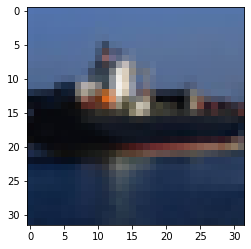

In [11]:
dataiter = iter(train_loader_nonorm)
images, labels = dataiter.next()

def imshow_nonorm(img):
    img = img     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    
# show images
imshow_nonorm(torchvision.utils.make_grid(images[10]))

print(classes[labels[10]])
#print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

**####Batch Normalization + L1 LOSS**

In [12]:
dropout_perc = 0.05

class BatchNormNet(nn.Module):
    def __init__(self):
        super(BatchNormNet, self).__init__()

        #BLOCK C1
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=(3, 3), padding=1, dilation = 1,bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Dropout(dropout_perc)
        ) # output_size = 32 ; #Receptive field = 3x3

        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3, 3), padding=1, dilation = 1,bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Dropout(dropout_perc)
        ) # output_size = 32; #Receptive field = 5x5
        
       #BLOCK C1 TRANSITION
        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=32, kernel_size=(1, 1), padding=0, bias=False),
        ) # output_size = 32; #Receptive field = 7x7

        #self.pool1 = nn.MaxPool2d(2, 2) # output_size = 16 ; #Receptive field = 8x8
        #Drop maxPooling and use strided convolution
        self.pool1 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3, 3), stride=2, padding=1, dilation =1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Dropout(dropout_perc)
        )
        #Use dilated kernels instead of Max pooling
        #self.pool1 = nn.Sequential(
        #    nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), dilation=2, padding=0, bias=False),
        #    nn.BatchNorm2d(16),
        #    nn.ReLU(),
        #    nn.Dropout(dropout_perc),
        #    nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), dilation=2, padding=0, bias=False),
        #    nn.BatchNorm2d(16),
        #    nn.ReLU(),
        #    nn.Dropout(dropout_perc),
        #    nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), dilation=2, padding=0, bias=False),
        #    nn.BatchNorm2d(16),
        #    nn.ReLU(),
        #    nn.Dropout(dropout_perc),
        #    nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), dilation=2, padding=0, bias=False),
        #    nn.BatchNorm2d(16),
        #    nn.ReLU(),
        #   nn.Dropout(dropout_perc)
        #    #nn.Conv2d(in_channels=64, out_channels=16, kernel_size=(1, 1), padding=0, bias=False),
        #)
        #BLOCK C2
        
        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, groups = 64, kernel_size=(3, 3), padding=2, dilation = 2 ,bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Dropout(dropout_perc)
        ) # output_size = 16; #Receptive field = 5x5
        
        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=256, groups = 128, kernel_size=(3, 3), padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Dropout(dropout_perc)
        ) # output_size = 16; #Receptive field = 5x5

        
        #BLOCK C2 TRANSITION
        self.convblock7 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=32, kernel_size=(1, 1), padding=0, bias=False),
        ) # output_size = 16; #Receptive field = 5x5
        
        
        #self.pool2 = nn.MaxPool2d(2, 2) # output_size = 8 ; #Receptive field = 8x8
        self.pool2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3, 3), stride=2, padding=1, dilation = 1,bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Dropout(dropout_perc)
        )

        #BLOCK C3
        
        self.convblock8 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, groups = 64, kernel_size=(3, 3), padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Dropout(dropout_perc)
        ) # output_size = 16; #Receptive field = 5x5
        
        self.convblock9 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=256, groups = 128, kernel_size=(3, 3), padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Dropout(dropout_perc)
        ) # output_size = 16; #Receptive field = 5x5

        #BLOCK C3 TRANSITION
        self.convblock10 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=32, kernel_size=(1, 1), padding=0, bias=False),
        ) # output_size = 16; #Receptive field = 5x5
        
        #self.pool2 = nn.MaxPool2d(2, 2) # output_size = 8 ; #Receptive field = 8x8
        self.pool3 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3, 3), stride=2, padding=1, dilation = 1,bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Dropout(dropout_perc)
        )
        #BLOCK C4
        
        self.convblock11 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, groups = 64, kernel_size=(3, 3), padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Dropout(dropout_perc)
        ) # output_size = 8; #Receptive field = 5x5
        
        self.convblock12 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=256, groups = 128 , kernel_size=(3, 3), padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Dropout(dropout_perc)
        ) # output_size = 8; #Receptive field = 5x5

        self.convblock25 = nn.Sequential(
            nn.Conv2d(in_channels=256, groups = 256, out_channels=512, kernel_size=(3, 3), padding=1, bias=False)
        ) # output_size = 8; #Receptive field = 5x5

                 
        # OUTPUT BLOCK
        self.gap = nn.Sequential(
            nn.AvgPool2d(kernel_size=4)
        ) # output_size = 1

        self.convblock13 = nn.Sequential(
            nn.Linear(512,10,0)
        )

    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.convblock4(x)
        
        x = self.pool1(x)
        
        x = self.convblock5(x)
        x = self.convblock6(x)
        x = self.convblock7(x)

        x = self.pool2(x)

        x = self.convblock8(x)
        x = self.convblock9(x)
        x = self.convblock10(x)

        x = self.pool3(x)
        
        x = self.convblock11(x)
        x = self.convblock12(x)
        x = self.convblock25(x)
        x = self.gap(x)
        
        x = x.view(x.size(0), -1)
        x = self.convblock13(x)
   
        return F.log_softmax(x, dim=-1)

In [13]:
model = BatchNormNet().to(device)
summary(model, input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             864
       BatchNorm2d-2           [-1, 32, 32, 32]              64
              ReLU-3           [-1, 32, 32, 32]               0
           Dropout-4           [-1, 32, 32, 32]               0
            Conv2d-5           [-1, 64, 32, 32]          18,432
       BatchNorm2d-6           [-1, 64, 32, 32]             128
              ReLU-7           [-1, 64, 32, 32]               0
           Dropout-8           [-1, 64, 32, 32]               0
            Conv2d-9           [-1, 32, 32, 32]           2,048
           Conv2d-10           [-1, 64, 16, 16]          18,432
      BatchNorm2d-11           [-1, 64, 16, 16]             128
             ReLU-12           [-1, 64, 16, 16]               0
          Dropout-13           [-1, 64, 16, 16]               0
           Conv2d-14          [-1, 128,

####LayerNorm Normalization + L1 LOSS

**`####Group normalization network + L1 LOSS`**

In [14]:
from tqdm import tqdm

test_fail_data = []
test_fail_target = []
test_pred_target = []
test_losses = []
test_acc = []
train_acc = []
train_losses = []

loss_function = nn.CrossEntropyLoss()

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)

  l1_lamda = 0.0001
  
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    #Cross entropy loss
    #loss = F.nll_loss(y_pred, target)
    loss = loss_function(y_pred,target)
    #

    ##Add L1 Loss
    l1 = 0
    for p in model.parameters():
      p_tensor = torch.sum(torch.abs(p))
      l1 += p_tensor

    loss = loss + l1_lamda * l1
    
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    test_fail_data = []
    test_fail_target = []
    test_pred_target = []

    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            #print(pred,target.view_as(pred))
            correct += pred.eq(target.view_as(pred)).sum().item()
            for i,x in enumerate(pred.eq(target.view_as(pred))):
              if not x:
                test_fail_data.append(data[i])
                test_fail_target.append(target[i])
                test_pred_target.append(pred[i])
                #print(target[i])

    test_losses.append(test_loss)
    
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))

    return test_losses, test_acc, test_fail_data, test_fail_target, test_pred_target;

**####Block to pass argment and call the Model**

Pass the model to be Invoked based on Input Argument

In [15]:
def main(input_model_type,EPOCHS):
  if input_model_type == 0:
    model = BatchNormNet().to(device)
    test_10_images, test_10_images_target , test_10_pred_target = run_train_test(model,EPOCHS,input_model_type)
    return test_10_images, test_10_images_target , test_10_pred_target ;
  elif input_model_type == 1:
    model = LayerNormNet().to(device)
    test_10_images, test_10_images_target , test_10_pred_target = run_train_test(model,EPOCHS,input_model_type)
    return test_10_images, test_10_images_target , test_10_pred_target ;
  elif input_model_type == 2:
    model = GroupNormNet().to(device)
    test_10_images, test_10_images_target , test_10_pred_target = run_train_test(model,EPOCHS,input_model_type)
    return test_10_images, test_10_images_target , test_10_pred_target ;
  else:
    print("Invalid input for input_model_type",input_model_type)
    print("Supported values are 0 = Batch Norm,1 = Layer Norm,2 = Group Norm")

def run_train_test(model,EPOCHS,input_model_type):
  summary(model, input_size=(3, 32, 32))
  optimizer = optim.SGD(model.parameters(), lr=0.02, momentum=0.9)
  scheduler = optim.lr_scheduler.StepLR(optimizer,step_size=12, gamma=0.7)

  for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    
    scheduler.step()
    
    print('Epoch {}, lr {}'.format(
        epoch, optimizer.param_groups[0]['lr']))
    
    train(model, device, train_loader, optimizer, epoch)
    
    test_losses, test_acc, test_fail_data, test_fail_target, test_pred_target = test(model, device, test_loader)
  
  #print(test_fail_data)
  fig, axs = plt.subplots(1, 2)
  if input_model_type == 0:
    fig.suptitle('Model Type: Batch normalization')
  if input_model_type == 1:
    fig.suptitle('Model Type: Layer normalization')
  if input_model_type == 2:
    fig.suptitle('Model Type: Group normalization')
  
  axs[0].set_title('Test/Validation Loss Graph')
  axs[0].set_xticks(np.arange(1,EPOCHS+1))
  #axs[0].xlabel('Test/Validation Loss Graph')
  #axs[0].ylabel('LOSS')
  axs[1].set_title('Test/Validation Accuracy Graph')
  axs[1].set_xticks(np.arange(1,EPOCHS+1))
  #axs[1].xlabel('Test/Validation Accuracy Graph')
  #axs[1].ylabel('Accuracy')
  
  axs[0].plot(test_losses)
  axs[1].plot(test_acc)

  test_10_images = []
  for i in range(0,10):
    test_10_images.append(test_fail_data[i])
  
  test_10_images_target = []
  for i in range(0,10):
    test_10_images_target.append(test_fail_target[i])

  test_10_pred_target = []
  for i in range(0,10):
    test_10_pred_target.append(test_pred_target[i])
  #print(test_10_images_target)

  print('Actual Labels')
  print(' '.join('%5s' % classes[test_10_images_target[j]] for j in range(0,10)))
  print('Predicted Labels')
  print(' '.join('%5s' % classes[test_10_pred_target[j]] for j in range(0,10)))

  test_10_images_unnorm = []
  for img in test_10_images:
    img = img.cpu()
    img = img.numpy()
    img[0] = img[0] * 0.247 + 0.4914
    img[1] = img[1] * 0.2435 + 0.4822
    img[2] = img[2] * 0.2616 + 0.4465

    img = torch.from_numpy(img)
    test_10_images_unnorm.append(img)
  
  grid = torchvision.utils.make_grid(torch.stack(test_10_images_unnorm).cpu(), nrow=5)
  plt.figure(figsize=(5,5))
  plt.imshow(np.transpose(grid, (1,2,0)))

  return test_10_images, test_10_images_target , test_10_pred_target;

**####Call to main function**

main(input_model_type,EPOCHS)

input_model_type:

Supported values are

0 = Train a model with Batch normalization

1 = Train a model with Layer normalization

2 = Train a model with Group Normalization

EPOCHS: num_epochs


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:134: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)
  0%|          | 0/391 [00:00<?, ?it/s]

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             864
       BatchNorm2d-2           [-1, 32, 32, 32]              64
              ReLU-3           [-1, 32, 32, 32]               0
           Dropout-4           [-1, 32, 32, 32]               0
            Conv2d-5           [-1, 64, 32, 32]          18,432
       BatchNorm2d-6           [-1, 64, 32, 32]             128
              ReLU-7           [-1, 64, 32, 32]               0
           Dropout-8           [-1, 64, 32, 32]               0
            Conv2d-9           [-1, 32, 32, 32]           2,048
           Conv2d-10           [-1, 64, 16, 16]          18,432
      BatchNorm2d-11           [-1, 64, 16, 16]             128
             ReLU-12           [-1, 64, 16, 16]               0
          Dropout-13           [-1, 64, 16, 16]               0
           Conv2d-14          [-1, 128,

Loss=2.104013442993164 Batch_id=390 Accuracy=35.42: 100%|██████████| 391/391 [00:16<00:00, 23.57it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 14364.5558, Accuracy: 4813/10000 (48.13%)

EPOCH: 1
Epoch 1, lr 0.02


Loss=2.139294147491455 Batch_id=390 Accuracy=48.41: 100%|██████████| 391/391 [00:16<00:00, 23.93it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 12032.2872, Accuracy: 5710/10000 (57.10%)

EPOCH: 2
Epoch 2, lr 0.02


Loss=1.8934171199798584 Batch_id=390 Accuracy=53.62: 100%|██████████| 391/391 [00:16<00:00, 23.58it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 10548.0713, Accuracy: 6282/10000 (62.82%)

EPOCH: 3
Epoch 3, lr 0.02


Loss=1.820120930671692 Batch_id=390 Accuracy=57.04: 100%|██████████| 391/391 [00:16<00:00, 23.67it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 10173.6916, Accuracy: 6448/10000 (64.48%)

EPOCH: 4
Epoch 4, lr 0.02


Loss=1.8745661973953247 Batch_id=390 Accuracy=58.94: 100%|██████████| 391/391 [00:16<00:00, 23.67it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 9004.5174, Accuracy: 6825/10000 (68.25%)

EPOCH: 5
Epoch 5, lr 0.02


Loss=1.7584638595581055 Batch_id=390 Accuracy=60.34: 100%|██████████| 391/391 [00:16<00:00, 23.61it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 8945.9235, Accuracy: 6907/10000 (69.07%)

EPOCH: 6
Epoch 6, lr 0.02


Loss=1.8351225852966309 Batch_id=390 Accuracy=61.83: 100%|██████████| 391/391 [00:16<00:00, 23.61it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 9260.0171, Accuracy: 6794/10000 (67.94%)

EPOCH: 7
Epoch 7, lr 0.02


Loss=1.481642246246338 Batch_id=390 Accuracy=62.63: 100%|██████████| 391/391 [00:16<00:00, 23.61it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 8157.9168, Accuracy: 7161/10000 (71.61%)

EPOCH: 8
Epoch 8, lr 0.02


Loss=1.6563711166381836 Batch_id=390 Accuracy=63.65: 100%|██████████| 391/391 [00:16<00:00, 23.48it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 8169.1360, Accuracy: 7098/10000 (70.98%)

EPOCH: 9
Epoch 9, lr 0.02


Loss=1.6334455013275146 Batch_id=390 Accuracy=64.03: 100%|██████████| 391/391 [00:16<00:00, 23.55it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 7756.6486, Accuracy: 7288/10000 (72.88%)

EPOCH: 10
Epoch 10, lr 0.02


Loss=1.539060115814209 Batch_id=390 Accuracy=64.85: 100%|██████████| 391/391 [00:16<00:00, 23.63it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 7809.3985, Accuracy: 7264/10000 (72.64%)

EPOCH: 11
Epoch 11, lr 0.013999999999999999


Loss=1.4329326152801514 Batch_id=390 Accuracy=66.72: 100%|██████████| 391/391 [00:16<00:00, 23.59it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 7186.4707, Accuracy: 7506/10000 (75.06%)

EPOCH: 12
Epoch 12, lr 0.013999999999999999


Loss=1.4129726886749268 Batch_id=390 Accuracy=67.44: 100%|██████████| 391/391 [00:16<00:00, 23.56it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 6969.7878, Accuracy: 7527/10000 (75.27%)

EPOCH: 13
Epoch 13, lr 0.013999999999999999


Loss=1.50102698802948 Batch_id=390 Accuracy=67.59: 100%|██████████| 391/391 [00:16<00:00, 23.74it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 6996.1375, Accuracy: 7572/10000 (75.72%)

EPOCH: 14
Epoch 14, lr 0.013999999999999999


Loss=1.7537543773651123 Batch_id=390 Accuracy=67.80: 100%|██████████| 391/391 [00:16<00:00, 23.40it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 6645.2458, Accuracy: 7712/10000 (77.12%)

EPOCH: 15
Epoch 15, lr 0.013999999999999999


Loss=1.5223698616027832 Batch_id=390 Accuracy=68.18: 100%|██████████| 391/391 [00:16<00:00, 23.55it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 7455.9299, Accuracy: 7371/10000 (73.71%)

EPOCH: 16
Epoch 16, lr 0.013999999999999999


Loss=1.4587388038635254 Batch_id=390 Accuracy=68.55: 100%|██████████| 391/391 [00:16<00:00, 23.76it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 7176.2716, Accuracy: 7479/10000 (74.79%)

EPOCH: 17
Epoch 17, lr 0.013999999999999999


Loss=1.4540599584579468 Batch_id=390 Accuracy=68.72: 100%|██████████| 391/391 [00:16<00:00, 23.53it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 6781.6263, Accuracy: 7639/10000 (76.39%)

EPOCH: 18
Epoch 18, lr 0.013999999999999999


Loss=1.445923089981079 Batch_id=390 Accuracy=68.90: 100%|██████████| 391/391 [00:16<00:00, 23.43it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 6817.3351, Accuracy: 7590/10000 (75.90%)

EPOCH: 19
Epoch 19, lr 0.013999999999999999


Loss=1.6125577688217163 Batch_id=390 Accuracy=69.08: 100%|██████████| 391/391 [00:16<00:00, 23.49it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 6392.1747, Accuracy: 7788/10000 (77.88%)

EPOCH: 20
Epoch 20, lr 0.013999999999999999


Loss=1.3236582279205322 Batch_id=390 Accuracy=69.55: 100%|██████████| 391/391 [00:16<00:00, 23.55it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 6267.3503, Accuracy: 7800/10000 (78.00%)

EPOCH: 21
Epoch 21, lr 0.013999999999999999


Loss=1.4143747091293335 Batch_id=390 Accuracy=69.38: 100%|██████████| 391/391 [00:16<00:00, 23.50it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 6297.5570, Accuracy: 7866/10000 (78.66%)

EPOCH: 22
Epoch 22, lr 0.013999999999999999


Loss=1.2208045721054077 Batch_id=390 Accuracy=69.48: 100%|██████████| 391/391 [00:16<00:00, 23.53it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 6420.3139, Accuracy: 7797/10000 (77.97%)

EPOCH: 23
Epoch 23, lr 0.009799999999999998


Loss=1.3463308811187744 Batch_id=390 Accuracy=71.19: 100%|██████████| 391/391 [00:16<00:00, 23.57it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 6145.1613, Accuracy: 7886/10000 (78.86%)

EPOCH: 24
Epoch 24, lr 0.009799999999999998


Loss=1.2096842527389526 Batch_id=390 Accuracy=71.26: 100%|██████████| 391/391 [00:16<00:00, 23.45it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 5765.1055, Accuracy: 7971/10000 (79.71%)

EPOCH: 25
Epoch 25, lr 0.009799999999999998


Loss=1.141637921333313 Batch_id=390 Accuracy=71.47: 100%|██████████| 391/391 [00:16<00:00, 23.47it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 5628.8713, Accuracy: 8057/10000 (80.57%)

EPOCH: 26
Epoch 26, lr 0.009799999999999998


Loss=1.5394346714019775 Batch_id=390 Accuracy=71.58: 100%|██████████| 391/391 [00:16<00:00, 23.52it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 5832.4861, Accuracy: 7955/10000 (79.55%)

EPOCH: 27
Epoch 27, lr 0.009799999999999998


Loss=1.4010870456695557 Batch_id=390 Accuracy=71.33: 100%|██████████| 391/391 [00:16<00:00, 23.32it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 5748.5429, Accuracy: 8016/10000 (80.16%)

EPOCH: 28
Epoch 28, lr 0.009799999999999998


Loss=1.2049373388290405 Batch_id=390 Accuracy=71.39: 100%|██████████| 391/391 [00:16<00:00, 23.22it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 5667.4794, Accuracy: 8061/10000 (80.61%)

EPOCH: 29
Epoch 29, lr 0.009799999999999998


Loss=1.3047120571136475 Batch_id=390 Accuracy=71.48: 100%|██████████| 391/391 [00:16<00:00, 23.18it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 6078.5519, Accuracy: 7896/10000 (78.96%)

EPOCH: 30
Epoch 30, lr 0.009799999999999998


Loss=1.3601782321929932 Batch_id=390 Accuracy=71.75: 100%|██████████| 391/391 [00:16<00:00, 23.34it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 5519.8360, Accuracy: 8073/10000 (80.73%)

EPOCH: 31
Epoch 31, lr 0.009799999999999998


Loss=1.3268903493881226 Batch_id=390 Accuracy=71.88: 100%|██████████| 391/391 [00:16<00:00, 23.24it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 5660.3937, Accuracy: 8040/10000 (80.40%)

EPOCH: 32
Epoch 32, lr 0.009799999999999998


Loss=1.2674381732940674 Batch_id=390 Accuracy=71.73: 100%|██████████| 391/391 [00:16<00:00, 23.45it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 5515.3806, Accuracy: 8075/10000 (80.75%)

EPOCH: 33
Epoch 33, lr 0.009799999999999998


Loss=1.2290759086608887 Batch_id=390 Accuracy=72.16: 100%|██████████| 391/391 [00:16<00:00, 23.37it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 5942.0874, Accuracy: 7924/10000 (79.24%)

EPOCH: 34
Epoch 34, lr 0.009799999999999998


Loss=1.3500328063964844 Batch_id=390 Accuracy=72.03: 100%|██████████| 391/391 [00:16<00:00, 23.33it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 5441.5005, Accuracy: 8107/10000 (81.07%)

EPOCH: 35
Epoch 35, lr 0.006859999999999998


Loss=1.3707177639007568 Batch_id=390 Accuracy=73.31: 100%|██████████| 391/391 [00:16<00:00, 23.33it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 5332.3793, Accuracy: 8179/10000 (81.79%)

EPOCH: 36
Epoch 36, lr 0.006859999999999998


Loss=1.5901713371276855 Batch_id=390 Accuracy=73.45: 100%|██████████| 391/391 [00:16<00:00, 23.23it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 5246.6209, Accuracy: 8173/10000 (81.73%)

EPOCH: 37
Epoch 37, lr 0.006859999999999998


Loss=0.9729031920433044 Batch_id=390 Accuracy=73.30: 100%|██████████| 391/391 [00:16<00:00, 23.20it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 5211.8760, Accuracy: 8240/10000 (82.40%)

EPOCH: 38
Epoch 38, lr 0.006859999999999998


Loss=1.210081696510315 Batch_id=390 Accuracy=73.60: 100%|██████████| 391/391 [00:16<00:00, 23.19it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 5194.3679, Accuracy: 8217/10000 (82.17%)

EPOCH: 39
Epoch 39, lr 0.006859999999999998


Loss=1.2034893035888672 Batch_id=390 Accuracy=73.53: 100%|██████████| 391/391 [00:16<00:00, 23.17it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 5468.8609, Accuracy: 8107/10000 (81.07%)

EPOCH: 40
Epoch 40, lr 0.006859999999999998


Loss=1.1818997859954834 Batch_id=390 Accuracy=73.60: 100%|██████████| 391/391 [00:16<00:00, 23.25it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 4996.0405, Accuracy: 8278/10000 (82.78%)

EPOCH: 41
Epoch 41, lr 0.006859999999999998


Loss=1.256211519241333 Batch_id=390 Accuracy=73.80: 100%|██████████| 391/391 [00:16<00:00, 23.21it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 5175.5125, Accuracy: 8199/10000 (81.99%)

EPOCH: 42
Epoch 42, lr 0.006859999999999998


Loss=1.137356162071228 Batch_id=390 Accuracy=74.00: 100%|██████████| 391/391 [00:16<00:00, 23.25it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 5243.5185, Accuracy: 8182/10000 (81.82%)

EPOCH: 43
Epoch 43, lr 0.006859999999999998


Loss=1.1427443027496338 Batch_id=390 Accuracy=73.51: 100%|██████████| 391/391 [00:16<00:00, 23.32it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 5278.7668, Accuracy: 8162/10000 (81.62%)

EPOCH: 44
Epoch 44, lr 0.006859999999999998


Loss=1.3347554206848145 Batch_id=390 Accuracy=73.79: 100%|██████████| 391/391 [00:16<00:00, 23.17it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 5280.1217, Accuracy: 8210/10000 (82.10%)

EPOCH: 45
Epoch 45, lr 0.006859999999999998


Loss=1.221360445022583 Batch_id=390 Accuracy=73.69: 100%|██████████| 391/391 [00:16<00:00, 23.28it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 5115.9870, Accuracy: 8239/10000 (82.39%)

EPOCH: 46
Epoch 46, lr 0.006859999999999998


Loss=1.1551357507705688 Batch_id=390 Accuracy=74.13: 100%|██████████| 391/391 [00:16<00:00, 23.24it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 5178.5190, Accuracy: 8171/10000 (81.71%)

EPOCH: 47
Epoch 47, lr 0.004801999999999998


Loss=1.1189978122711182 Batch_id=390 Accuracy=74.47: 100%|██████████| 391/391 [00:16<00:00, 23.23it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 4917.7543, Accuracy: 8296/10000 (82.96%)

EPOCH: 48
Epoch 48, lr 0.004801999999999998


Loss=1.0997564792633057 Batch_id=390 Accuracy=74.84: 100%|██████████| 391/391 [00:16<00:00, 23.16it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 5361.1775, Accuracy: 8150/10000 (81.50%)

EPOCH: 49
Epoch 49, lr 0.004801999999999998


Loss=1.1357357501983643 Batch_id=390 Accuracy=74.94: 100%|██████████| 391/391 [00:16<00:00, 23.30it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 4671.9293, Accuracy: 8384/10000 (83.84%)

EPOCH: 50
Epoch 50, lr 0.004801999999999998


Loss=1.1179606914520264 Batch_id=390 Accuracy=75.28: 100%|██████████| 391/391 [00:16<00:00, 23.11it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 4916.6747, Accuracy: 8285/10000 (82.85%)

EPOCH: 51
Epoch 51, lr 0.004801999999999998


Loss=1.0931633710861206 Batch_id=390 Accuracy=74.95: 100%|██████████| 391/391 [00:16<00:00, 23.13it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 4867.6790, Accuracy: 8316/10000 (83.16%)

EPOCH: 52
Epoch 52, lr 0.004801999999999998


Loss=1.1491758823394775 Batch_id=390 Accuracy=75.00: 100%|██████████| 391/391 [00:16<00:00, 23.13it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 4994.8711, Accuracy: 8266/10000 (82.66%)

EPOCH: 53
Epoch 53, lr 0.004801999999999998


Loss=1.4289591312408447 Batch_id=390 Accuracy=74.96: 100%|██████████| 391/391 [00:16<00:00, 23.10it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 4829.8487, Accuracy: 8335/10000 (83.35%)

EPOCH: 54
Epoch 54, lr 0.004801999999999998


Loss=0.9119676351547241 Batch_id=390 Accuracy=75.24: 100%|██████████| 391/391 [00:16<00:00, 23.26it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 4956.9904, Accuracy: 8259/10000 (82.59%)

EPOCH: 55
Epoch 55, lr 0.004801999999999998


Loss=1.1483098268508911 Batch_id=390 Accuracy=74.99: 100%|██████████| 391/391 [00:17<00:00, 22.98it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 4519.4183, Accuracy: 8444/10000 (84.44%)

EPOCH: 56
Epoch 56, lr 0.004801999999999998


Loss=1.1858116388320923 Batch_id=390 Accuracy=74.94: 100%|██████████| 391/391 [00:16<00:00, 23.05it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 4796.9354, Accuracy: 8335/10000 (83.35%)

EPOCH: 57
Epoch 57, lr 0.004801999999999998


Loss=1.3097010850906372 Batch_id=390 Accuracy=74.80: 100%|██████████| 391/391 [00:16<00:00, 23.11it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 5123.1407, Accuracy: 8221/10000 (82.21%)

EPOCH: 58
Epoch 58, lr 0.004801999999999998


Loss=1.2828761339187622 Batch_id=390 Accuracy=75.38: 100%|██████████| 391/391 [00:16<00:00, 23.07it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 4875.3039, Accuracy: 8323/10000 (83.23%)

EPOCH: 59
Epoch 59, lr 0.0033613999999999983


Loss=0.9094346761703491 Batch_id=390 Accuracy=75.71: 100%|██████████| 391/391 [00:16<00:00, 23.11it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 4532.9532, Accuracy: 8446/10000 (84.46%)

EPOCH: 60
Epoch 60, lr 0.0033613999999999983


Loss=1.2446707487106323 Batch_id=390 Accuracy=75.82: 100%|██████████| 391/391 [00:16<00:00, 23.02it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 4567.3887, Accuracy: 8432/10000 (84.32%)

EPOCH: 61
Epoch 61, lr 0.0033613999999999983


Loss=1.1569586992263794 Batch_id=390 Accuracy=76.33: 100%|██████████| 391/391 [00:17<00:00, 22.99it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 4612.5611, Accuracy: 8442/10000 (84.42%)

EPOCH: 62
Epoch 62, lr 0.0033613999999999983


Loss=1.0579099655151367 Batch_id=390 Accuracy=76.12: 100%|██████████| 391/391 [00:17<00:00, 22.96it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 4635.4397, Accuracy: 8414/10000 (84.14%)

EPOCH: 63
Epoch 63, lr 0.0033613999999999983


Loss=1.2173446416854858 Batch_id=390 Accuracy=76.26: 100%|██████████| 391/391 [00:16<00:00, 23.32it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 4532.2932, Accuracy: 8456/10000 (84.56%)

EPOCH: 64
Epoch 64, lr 0.0033613999999999983


Loss=1.0478087663650513 Batch_id=390 Accuracy=76.19: 100%|██████████| 391/391 [00:16<00:00, 23.01it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 4438.2650, Accuracy: 8470/10000 (84.70%)

EPOCH: 65
Epoch 65, lr 0.0033613999999999983


Loss=1.0378587245941162 Batch_id=390 Accuracy=76.36: 100%|██████████| 391/391 [00:17<00:00, 22.87it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 4330.4371, Accuracy: 8497/10000 (84.97%)

EPOCH: 66
Epoch 66, lr 0.0033613999999999983


Loss=1.1568562984466553 Batch_id=390 Accuracy=76.38: 100%|██████████| 391/391 [00:17<00:00, 22.99it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 4566.0271, Accuracy: 8432/10000 (84.32%)

EPOCH: 67
Epoch 67, lr 0.0033613999999999983


Loss=1.1876683235168457 Batch_id=390 Accuracy=76.13: 100%|██████████| 391/391 [00:17<00:00, 22.94it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 4546.9652, Accuracy: 8437/10000 (84.37%)

EPOCH: 68
Epoch 68, lr 0.0033613999999999983


Loss=1.2420706748962402 Batch_id=390 Accuracy=76.31: 100%|██████████| 391/391 [00:17<00:00, 22.96it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 4561.8717, Accuracy: 8424/10000 (84.24%)

EPOCH: 69
Epoch 69, lr 0.0033613999999999983


Loss=1.0068880319595337 Batch_id=390 Accuracy=76.20: 100%|██████████| 391/391 [00:17<00:00, 22.91it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 4613.2454, Accuracy: 8436/10000 (84.36%)

EPOCH: 70
Epoch 70, lr 0.0033613999999999983


Loss=1.0148117542266846 Batch_id=390 Accuracy=76.24: 100%|██████████| 391/391 [00:17<00:00, 22.88it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 4478.4248, Accuracy: 8485/10000 (84.85%)

EPOCH: 71
Epoch 71, lr 0.002352979999999999


Loss=0.9119007587432861 Batch_id=390 Accuracy=76.82: 100%|██████████| 391/391 [00:17<00:00, 22.93it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 4325.2817, Accuracy: 8509/10000 (85.09%)

EPOCH: 72
Epoch 72, lr 0.002352979999999999


Loss=0.9068740606307983 Batch_id=390 Accuracy=77.02: 100%|██████████| 391/391 [00:17<00:00, 22.99it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 4201.4133, Accuracy: 8558/10000 (85.58%)

EPOCH: 73
Epoch 73, lr 0.002352979999999999


Loss=0.9022310972213745 Batch_id=390 Accuracy=77.22: 100%|██████████| 391/391 [00:17<00:00, 22.89it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 4428.0250, Accuracy: 8488/10000 (84.88%)

EPOCH: 74
Epoch 74, lr 0.002352979999999999


Loss=1.0843535661697388 Batch_id=390 Accuracy=77.12: 100%|██████████| 391/391 [00:16<00:00, 23.13it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 4624.6649, Accuracy: 8398/10000 (83.98%)

EPOCH: 75
Epoch 75, lr 0.002352979999999999


Loss=1.08828604221344 Batch_id=390 Accuracy=77.27: 100%|██████████| 391/391 [00:17<00:00, 22.87it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 4515.2105, Accuracy: 8419/10000 (84.19%)

EPOCH: 76
Epoch 76, lr 0.002352979999999999


Loss=0.9597681760787964 Batch_id=390 Accuracy=77.02: 100%|██████████| 391/391 [00:17<00:00, 22.85it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 4247.1061, Accuracy: 8537/10000 (85.37%)

EPOCH: 77
Epoch 77, lr 0.002352979999999999


Loss=0.9631685614585876 Batch_id=390 Accuracy=77.16: 100%|██████████| 391/391 [00:17<00:00, 22.86it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 4183.8303, Accuracy: 8570/10000 (85.70%)

EPOCH: 78
Epoch 78, lr 0.002352979999999999


Loss=0.9628319144248962 Batch_id=390 Accuracy=77.33: 100%|██████████| 391/391 [00:16<00:00, 23.12it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 4307.4891, Accuracy: 8517/10000 (85.17%)

EPOCH: 79
Epoch 79, lr 0.002352979999999999


Loss=1.0912469625473022 Batch_id=390 Accuracy=77.02: 100%|██████████| 391/391 [00:16<00:00, 23.09it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 4289.9711, Accuracy: 8547/10000 (85.47%)

EPOCH: 80
Epoch 80, lr 0.002352979999999999


Loss=1.047682285308838 Batch_id=390 Accuracy=77.12: 100%|██████████| 391/391 [00:17<00:00, 22.90it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 4405.1571, Accuracy: 8493/10000 (84.93%)

EPOCH: 81
Epoch 81, lr 0.002352979999999999


Loss=0.8536891937255859 Batch_id=390 Accuracy=77.24: 100%|██████████| 391/391 [00:17<00:00, 23.00it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 4467.4841, Accuracy: 8458/10000 (84.58%)

EPOCH: 82
Epoch 82, lr 0.002352979999999999


Loss=1.0468387603759766 Batch_id=390 Accuracy=77.25: 100%|██████████| 391/391 [00:16<00:00, 23.05it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 4330.1561, Accuracy: 8485/10000 (84.85%)

EPOCH: 83
Epoch 83, lr 0.0016470859999999992


Loss=0.9734367728233337 Batch_id=390 Accuracy=77.87: 100%|██████████| 391/391 [00:17<00:00, 22.96it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 4308.5833, Accuracy: 8551/10000 (85.51%)

EPOCH: 84
Epoch 84, lr 0.0016470859999999992


Loss=0.8512183427810669 Batch_id=390 Accuracy=78.18: 100%|██████████| 391/391 [00:17<00:00, 22.92it/s]



Test set: Average loss: 4128.7035, Accuracy: 8590/10000 (85.90%)

Actual Labels
 ship   dog horse horse  bird  bird   dog   cat horse  bird
Predicted Labels
plane  bird  deer  deer  deer plane  bird  ship  deer  frog


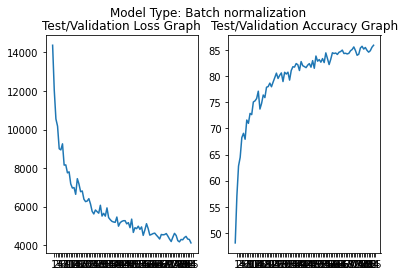

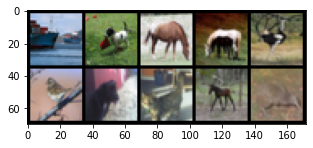

In [16]:
test_10_images, test_10_images_target , test_10_pred_target = main(0,85)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


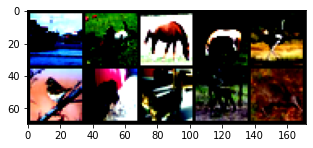

In [17]:
  grid = torchvision.utils.make_grid(torch.stack(test_10_images).cpu(), nrow=5)
  plt.figure(figsize=(5,5))
  plt.imshow(np.transpose(grid, (1,2,0)))

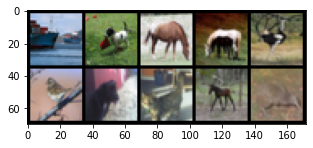

In [18]:
test_10_images_unnorm = []
for img in test_10_images:
  img = img.cpu()
  img = img.numpy()
  img[0] = img[0] * 0.247 + 0.4914
  img[1] = img[1] * 0.2435 + 0.4822
  img[2] = img[2] * 0.2616 + 0.4465

  img = torch.from_numpy(img)
  test_10_images_unnorm.append(img)

grid = torchvision.utils.make_grid(torch.stack(test_10_images_unnorm).cpu(), nrow=5)
plt.figure(figsize=(5,5))
plt.imshow(np.transpose(grid, (1,2,0)))
  
